In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
#Define Xception model
class Xception(nn.Module):
    def __init__(self, num_classes=10):
        super(Xception, self).__init__()
        # Entry flow
        self.entry_flow = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Input: 28x28x1 -> Output: 14x14x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: 14x14x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Depthwise separable convolution block
        def depthwise_separable(in_channels, out_channels, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Middle flow
        self.middle_flow = nn.Sequential(
            depthwise_separable(64, 128, stride=2),  # Output: 7x7x128
            depthwise_separable(128, 128),
            depthwise_separable(128, 128)
        )

        # Exit flow
        self.exit_flow = nn.Sequential(
            depthwise_separable(128, 256, stride=2),  # Output: 4x4x256
            depthwise_separable(256, 512),
            nn.AdaptiveAvgPool2d((1, 1))  # Output: 1x1x512
        )

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Ensure the input size is 28x28
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 11.7MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.21MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1/10
Training Loss: 0.1776
Test Accuracy: 98.40%
Epoch 2/10
Training Loss: 0.0503
Test Accuracy: 98.23%
Epoch 3/10
Training Loss: 0.0352
Test Accuracy: 98.38%
Epoch 4/10
Training Loss: 0.0292
Test Accuracy: 98.73%
Epoch 5/10
Training Loss: 0.0261
Test Accuracy: 99.03%
Epoch 6/10
Training Loss: 0.0196
Test Accuracy: 99.05%
Epoch 7/10
Training Loss: 0.0189
Test Accuracy: 98.95%
Epoch 8/10
Training Loss: 0.0161
Test Accuracy: 98.91%
Epoch 9/10
Training Loss: 0.0153
Test Accuracy: 98.84%
Epoch 10/10
Training Loss: 0.0136
Test Accuracy: 98.70%

Final Metrics for MNIST using Xception:
Accuracy: 98.70%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


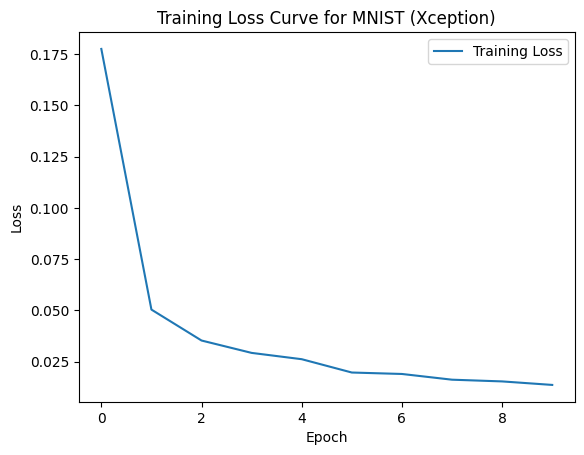

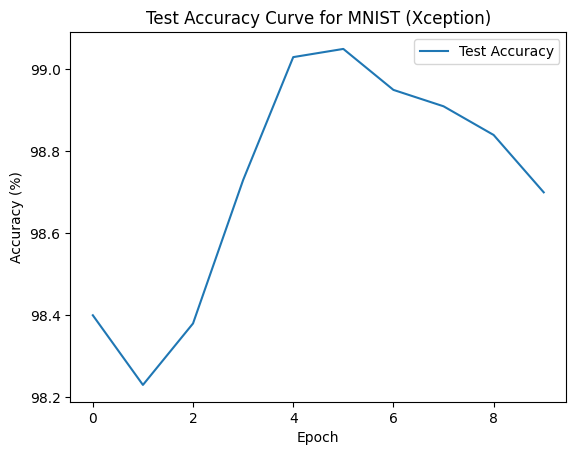

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = Xception(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for MNIST using Xception:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for MNIST (Xception)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for MNIST (Xception)')
plt.legend()
plt.show()

FMNIST

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.53MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 25.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1/10
Training Loss: 0.4544
Test Accuracy: 87.03%
Epoch 2/10
Training Loss: 0.2912
Test Accuracy: 89.32%
Epoch 3/10
Training Loss: 0.2449
Test Accuracy: 89.90%
Epoch 4/10
Training Loss: 0.2176
Test Accuracy: 90.30%
Epoch 5/10
Training Loss: 0.1981
Test Accuracy: 90.59%
Epoch 6/10
Training Loss: 0.1808
Test Accuracy: 91.12%
Epoch 7/10
Training Loss: 0.1621
Test Accuracy: 90.74%
Epoch 8/10
Training Loss: 0.1506
Test Accuracy: 90.85%
Epoch 9/10
Training Loss: 0.1391
Test Accuracy: 91.24%
Epoch 10/10
Training Loss: 0.1287
Test Accuracy: 91.28%

Final Metrics for FMNIST using Xception:
Accuracy: 91.28%
Precision: 0.91
Recall: 0.91
F1 Score: 0.91


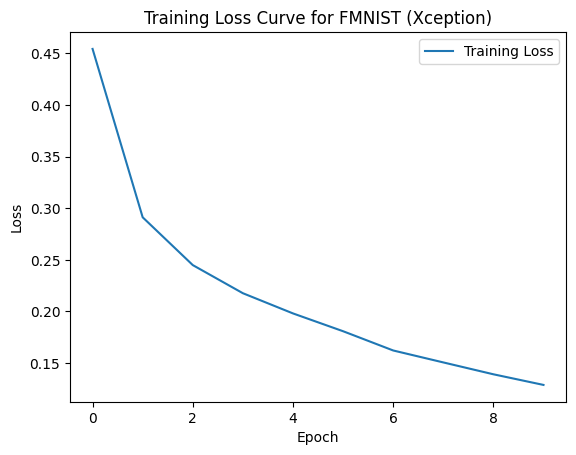

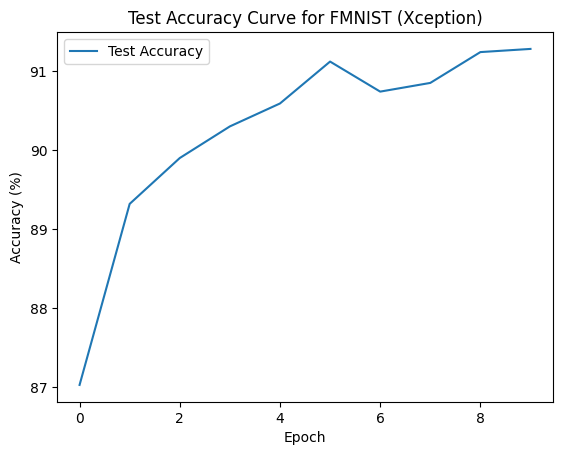

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = Xception(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for FMNIST using Xception:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for FMNIST (Xception)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for FMNIST (Xception)')
plt.legend()
plt.show()

CIFAR-10

100%|██████████| 170M/170M [00:02<00:00, 76.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/20
Training Loss: 1.5305
Test Accuracy: 50.58%
Epoch 2/20
Training Loss: 1.2078
Test Accuracy: 61.90%
Epoch 3/20
Training Loss: 1.0640
Test Accuracy: 65.05%
Epoch 4/20
Training Loss: 0.9500
Test Accuracy: 68.62%
Epoch 5/20
Training Loss: 0.8705
Test Accuracy: 70.52%
Epoch 6/20
Training Loss: 0.8007
Test Accuracy: 71.66%
Epoch 7/20
Training Loss: 0.7561
Test Accuracy: 74.61%
Epoch 8/20
Training Loss: 0.7128
Test Accuracy: 75.60%
Epoch 9/20
Training Loss: 0.6830
Test Accuracy: 76.25%
Epoch 10/20
Training Loss: 0.6498
Test Accuracy: 77.66%
Epoch 11/20
Training Loss: 0.6273
Test Accuracy: 78.26%
Epoch 12/20
Training Loss: 0.6024
Test Accuracy: 79.40%
Epoch 13/20
Training Loss: 0.5804
Test Accuracy: 79.11%
Epoch 14/20
Training Loss: 0.5568
Test Accuracy: 79.30%
Epoch 15/20
Training Loss: 0.5428
Test Accuracy: 80.30%
Epoch 16/20
Training Loss: 0.5290
Test Accuracy: 80.72%
Epoch 17/20
Training Los

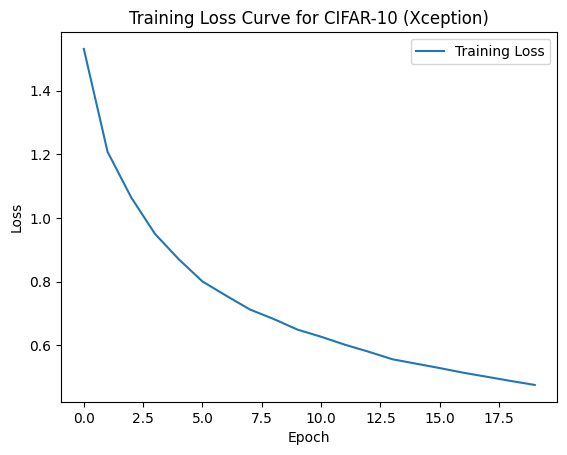

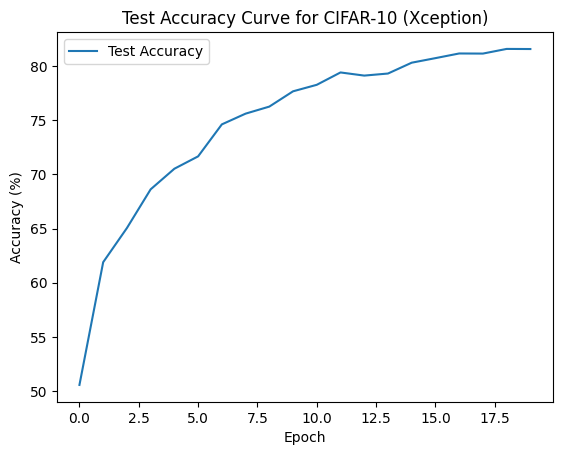

In [5]:
# Define Xception-like Model for CIFAR-10
class Xception(nn.Module):
    def __init__(self, num_classes=10):
        super(Xception, self).__init__()
        # Entry flow
        self.entry_flow = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Input: 32x32x3 -> Output: 16x16x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Depthwise separable convolution block
        def depthwise_separable(in_channels, out_channels, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Middle flow
        self.middle_flow = nn.Sequential(
            depthwise_separable(64, 128, stride=2),  # Output: 8x8x128
            depthwise_separable(128, 128),
            depthwise_separable(128, 128)
        )

        # Exit flow
        self.exit_flow = nn.Sequential(
            depthwise_separable(128, 256, stride=2),  # Output: 4x4x256
            depthwise_separable(256, 512),
            nn.AdaptiveAvgPool2d((1, 1))  # Output: 1x1x512
        )

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Data Transformations and CIFAR-10 Dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = Xception(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation
num_epochs = 20
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for CIFAR-10 using Xception:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for CIFAR-10 (Xception)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for CIFAR-10 (Xception)')
plt.legend()
plt.show()